

********* November 2000 data**************** 




,transaction_dt,customer_id,age_group,pin_code,product_subclass,product_id,amount,asset,sales_price
1,2000-11-01,00046855,D,E,110411,4710085120468,3,51,57
2,2000-11-01,00539166,E,E,130315,4714981010038,2,56,48
3,2000-11-01,00663373,F,E,110217,4710265847666,1,180,135




********* December 2000 data**************** 




,transaction_dt,customer_id,age_group,pin_code,product_subclass,product_id,amount,asset,sales_price
1,2000-12-01,00207423,C,E,530101,4710054134403,1,92,99
2,2000-12-01,00329002,F,E,590514,4710049000973,1,41,49
3,2000-12-01,01657951,E,E,120103,4710011401135,1,23,29




********* January 2021 data**************** 




,transaction_dt,customer_id,age_group,pin_code,product_subclass,product_id,amount,asset,sales_price
1,2001-01-01,00141833,F,F,130207,4710105011011,2,44,52
2,2001-01-01,01376753,E,E,110217,4710265849066,1,150,129
3,2001-01-01,01603071,E,G,100201,4712019100607,1,35,39




********* Feb 2021 data**************** 




,transaction_dt,customer_id,age_group,pin_code,product_subclass,product_id,amount,asset,sales_price
1,2001-02-01,00557818,H,E,500210,4710114105046,1,123,135
2,2001-02-01,01677683,C,B,711310,4902520163103,6,840,894
3,2001-02-01,01900910,A,D,500206,4710036003598,1,26,33


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817741 entries, 0 to 817740
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_dt    817741 non-null  datetime64[ns]
 1   customer_id       817741 non-null  object        
 2   product_subclass  817741 non-null  int64         
 3   product_id        817741 non-null  int64         
 4   amount            817741 non-null  int64         
 5   asset             817741 non-null  int64         
 6   sales_price       817741 non-null  int64         
 7   age_label         817741 non-null  object        
 8   age_int           817741 non-null  int64         
 9   pin_code_int      817741 non-null  int64         
 10  age_group_A       817741 non-null  int32         
 11  age_group_B       817741 non-null  int32         
 12  age_group_C       817741 non-null  int32         
 13  age_group_D       817741 non-null  int32         
 14  age_

None

transaction_dt,customer_id,age_int,product_subclass,product_id,pin_code_int,asset,amount,sales_price
2000-11-01 00:00:00,02101750,3,130315,4714981010038,5,28,1,24
2000-11-01 00:00:00,02144511,1,110401,4710088410382,5,44,1,55
2000-11-01 00:00:00,02144511,1,100312,37000445111,5,38,1,47
2000-11-01 00:00:00,02144511,1,100205,4711372660094,5,58,1,76
2000-11-01 00:00:00,02144511,1,110401,4710008290032,5,46,1,57


transaction_dt,customer_id,age_int,product_subclass,product_id,pin_code_int,asset,amount,sales_price,year,month,week,day
2000-11-01 00:00:00,02101750,3,130315,4714981010038,5,28,1,24,2000,11,44,1
2000-11-01 00:00:00,02144511,1,110401,4710088410382,5,44,1,55,2000,11,44,1
2000-11-01 00:00:00,02144511,1,100312,37000445111,5,38,1,47,2000,11,44,1
2000-11-01 00:00:00,02144511,1,100205,4711372660094,5,58,1,76,2000,11,44,1
2000-11-01 00:00:00,02144511,1,110401,4710008290032,5,46,1,57,2000,11,44,1


Number of Large Orders 23


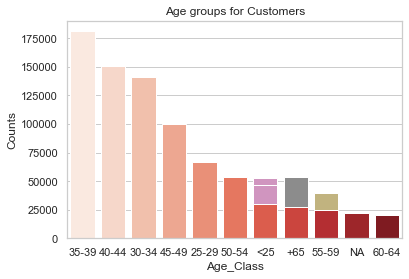

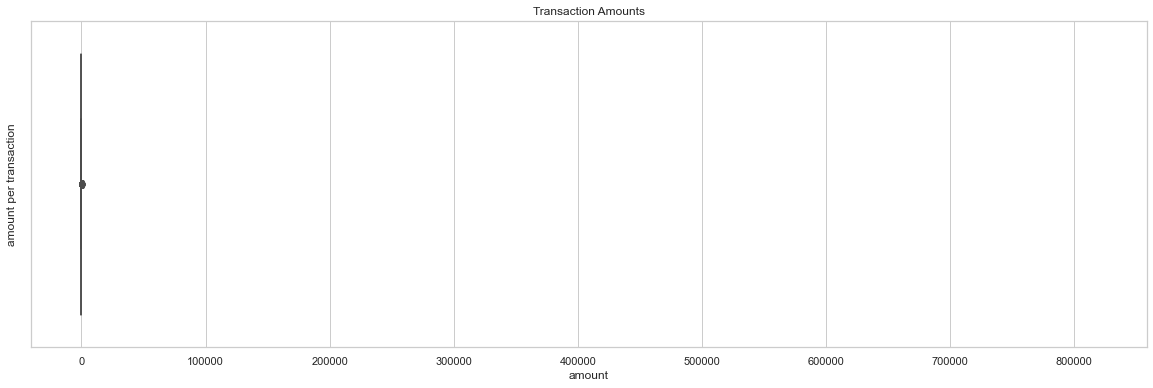

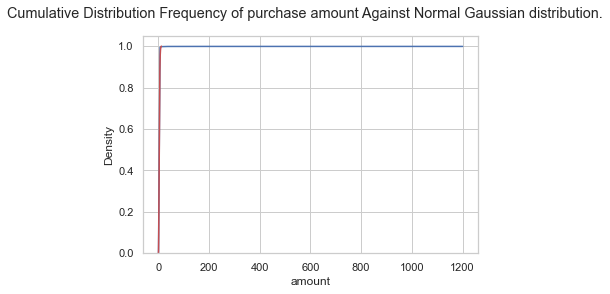

<Figure size 432x288 with 0 Axes>

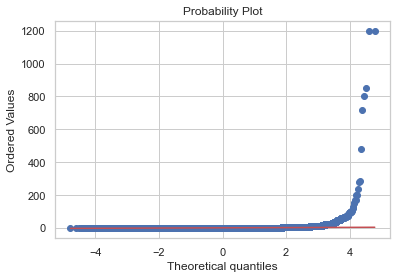

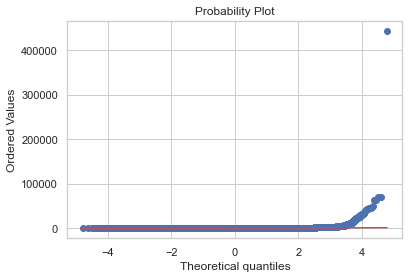

test statistic:  4963437.687618293
P-value:  0.0 
Conclusion: Not a normal distribution.
test statistic:  4310127.30717614
P-value:  0.0 
Conclusion: Not a normal distribution.
Median: 1.0
Outer Fence: -228.0 & 402.0
Number of Strong Outliers: 34788
Median: 1.0
Inner Fence: -93.0 & 267.0
Number of Mild Outliers: 69184


Recency Frequency Monetary       
                           mean     mean     mean   count 
RMF_Segment                                               
First segment customers    15.7     37.4    4906.3   18796
Second segment customers   59.9      9.8    1364.5   10647
Third segment customers    97.6      3.6     387.6    2823

In [1]:
from ipynb.fs.full.DSC680_project1_EDA import *

In [34]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from xgboost import XGBClassifier
from tqdm import tqdm

In [5]:
dataFolder = 'C:\BU\DSC680\project1\data'

In [12]:
def add_transaction_id(df: pd.DataFrame) -> pd.DataFrame:
    """Create transaction id for each product purchased (row in df). Products in the same basket have the same transaction id.
    Args:
            df: Dataframe which includes all the product purchased.

        Returns:
            df: Add transaction id to the input df.
    """
    df['trans_id'] =  df['customer_id'].astype(str) + df['year'].astype(str)+  df['month'].astype(str) +  df['day'].astype(str) 
    # assume each customer only make at most one transaction everyday
    df = df.sort_values(['trans_id']) # sort before finding the products in the same basket
    cust_id = df.customer_id.values[0]
    trans_buf_id = df.trans_id.values[0]
    trans = 0
    trans_id_list = []
    for i in tqdm(range(df.shape[0])):
        if df.customer_id.values[i] == cust_id:
            if df.trans_id.values[i] == trans_buf_id:
                trans_id_list.append(trans)
            else:
                trans += 1
                trans_buf_id = df.trans_id.values[i]
                trans_id_list.append(trans)
        else:
            cust_id = df.customer_id.values[i]
            trans_buf_id = df.trans_id.values[i]
            trans = 0
            trans_id_list.append(trans)
    df['trans_id'] = trans_id_list

    return df

In [24]:
def create_feature_for_one_customer(df_cust: pd.DataFrame, features: list, targets: list, train_test: list):
    """Create modeling features for each cutomer. Uses each transaction's previous two transactions information.
    Args:
        df_cust: Dataframe which includes all the transactions made by a single customer.
        features: a list of lists;
                    day of the week of the transactions, difference between the current transaction and the previous two transactions in days,
                    amount of all products, amount of the certain product, item prices, month of the transactions, product information, 
                    customer information. 
        targets: a list of 0, 1. 0 indicates a product is not purchased in the current transaction.
                1 indicates a product is purchased in the current transaction.
        train_test: a list of 0, 1. 1 indicates the corresponding feature will be usesd for training.
                0 indicates the corresponding feature will be used for tessting.
    """

    if df_cust.trans_id.max() < 4: # exclude customers with less than 4 transactions
        return

    for i in range(2, df_cust.trans_id.max() + 1): # start from the third transaction of each cutomer
        if i == df_cust.trans_id.max(): # if it is the last order
            train_test = 0
        else:
            train_test = 1
        df_prev = df_cust.loc[df_cust.trans_id.isin([i - 1, i - 2])].copy()
        df_prev_1 = df_prev.loc[df_prev.trans_id == i - 1]
        df_prev_2 = df_prev.loc[df_prev.trans_id == i - 2]
        curr_product = set(df_cust.loc[df_cust.trans_id == i,'product_id'])
        curr_date = df_cust.loc[df_cust.trans_id == i,'transaction_dt'].values[0]
        feature = []
        last_weekday = df_prev_1['day'].values[0]
        last_weekday_2 = df_prev_2['day'].values[0]
        this_weekday = df_cust.loc[df_cust.trans_id == i, 'day'].values[0]
        diff_last_day = (curr_date - df_prev_1['transaction_dt'].values[0]) / np.timedelta64(1, 'D')
        diff_last_day_2 = (curr_date - df_prev_2['transaction_dt'].values[0]) / np.timedelta64(1, 'D')
        last_all_amount = df_prev_1['amount'].sum()
        last_all_amount_2 = df_prev_2['amount'].sum()
        cust_area = df_cust['pin_code_int'].values[0]
        cust_age = df_cust['age_int'].values[0]
        last_month = str(df_prev_1.transaction_dt.values[0])[5:7]
        last_month_2 = str(df_prev_2.transaction_dt.values[0])[5:7]
        cust_id = df_cust['customer_id'].values[0]
        for prod_id in df_prev.product_id.unique():
            if prod_id in curr_product:
                targets.append(1)
            else:
                targets.append(0)
            dfdf_last = df_prev_1.loc[(df_prev_1.product_id == prod_id)].copy()
            dfdf_last_2 = df_prev_2.loc[(df_prev_2.product_id == prod_id)].copy()
            last_amount = 0
            last_amount_2 = 0
            last_price = 0
            last_price_2 = 0

            try:
                last_amount = dfdf_last['amount'].values[0]
                last_price = dfdf_last['sales_price'].values[0] / last_amount
            except:
                None
        
            try:
                last_amount_2 = dfdf_last_2['amount'].values[0]
                last_price_2 = dfdf_last_2['sales_price'].values[0] / last_amount_2
            except:
                None
        
            subcls = df_prev.loc[df_prev.product_id == prod_id,'product_subclass'].values[0]
            feature = [last_weekday, last_weekday_2, this_weekday, diff_last_day, diff_last_day_2, last_all_amount, last_all_amount_2,
                        last_amount, last_amount_2, last_price, last_price_2, last_month, last_month_2, int(subcls), int(prod_id), cust_area, 
                        cust_age, cust_id, train_test]
            features.append(feature)

    return

In [8]:
def create_feature(df: pd.DataFrame) -> pd.DataFrame:
    """Create features and targets from the transaction dataframe.
    
    Args:
        df: Dataframe which includes all transactions.
        
    Returns:
        df_feature_target: a dataframe includes features and targets.
        df_feature_target['Y'] are the targets.
    """

    cust_id = df.customer_id.values[0]
    start = 0
    features = [] # initial feature sets
    targets = [] # initial targets
    train_test = [] # initial train_test indicator
    for i in tqdm(range(df.shape[0])): # find transactions of each customer
        if df['customer_id'].values[i] == cust_id:
            continue
        df_cust = df.iloc[start:i,:].copy()
        create_feature_for_one_customer(df_cust, features, targets, train_test)
        cust_id = df.customer_id.values[i]
        start = i

    df_feature_target = pd.DataFrame(features)
    df_feature_target['Y'] = targets

    return df_feature_target

In [9]:
def train_test_split(df_feaure_target: pd.DataFrame) -> (np.array, np.array, np.array, np.array):
    """Onehot encoding plus train test split.
    Args:
        df_feaure_target: Dataframe with raw features and targets.
        
    Returns:
        X_train:
        X_test:
        y_train:
        y_test:
    """
    # onehot encoding customer area information
    label_encoder = LabelEncoder()
    lb_f = label_encoder.fit_transform(df_feaure_target[15]).reshape(-1,1)
    one_hot = OneHotEncoder(sparse=False)
    oh_f = one_hot.fit_transform(lb_f)

    # onehot encoding customer age information
    label_encoder = LabelEncoder()
    lb_f = label_encoder.fit_transform(df_feaure_target[16]).reshape(-1,1)
    one_hot = OneHotEncoder(sparse=False)
    oh_f_1 = one_hot.fit_transform(lb_f)

    bools = df_feaure_target[18] == 1 # identify training set
    del df_feaure_target[15], df_feaure_target[16], df_feaure_target[18]

    X = df_feaure_target.iloc[:,:-1].values
    X = np.concatenate((X, oh_f), axis=1)
    X = np.concatenate((X, oh_f_1), axis=1) 

    Y = df_feaure_target.iloc[:,-1].values

    X_train, X_test, y_train, y_test = X[bools, :], X[~bools, :], Y[bools], Y[~bools]

    return X_train, X_test, y_train, y_test

In [36]:
def plt_auc(model, X_test, Y_test, test_start):
    """Plot ROC area and return roc score.
    """
    probs = model.predict_proba(X_test)

    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title(str(test_start) + '\nReceiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc

In [70]:
cust_data_subset['Log_Unit_Price']=np.log(cust_data_subset['unit_price'])

In [71]:
cust_data_subset.head()

,transaction_dt,customer_id,age_int,product_subclass,product_id,pin_code_int,asset,amount,sales_price,year,month,week,day,unit_price,trans_id,Log_Unit_Price
753166,2000-11-01,02101750,3,130315,4714981010038,5,28,1,24,2000,11,44,1,24.0,021017502000111,3.178
787527,2000-11-01,02144511,1,110401,4710088410382,5,44,1,55,2000,11,44,1,55.0,021445112000111,4.007
787526,2000-11-01,02144511,1,100312,37000445111,5,38,1,47,2000,11,44,1,47.0,021445112000111,3.850
787525,2000-11-01,02144511,1,100205,4711372660094,5,58,1,76,2000,11,44,1,76.0,021445112000111,4.331
787524,2000-11-01,02144511,1,110401,4710008290032,5,46,1,57,2000,11,44,1,57.0,021445112000111,4.043


In [78]:
temp_df=cust_data_subset[['transaction_dt','customer_id','amount','unit_price','Log_Unit_Price','trans_id']]
temp_df['total_sum']=temp_df['amount']*temp_df['unit_price']
rmf_df=temp_df.groupby(['customer_id','transaction_dt','trans_id']).sum()
rmf_df['frequency']=1
rmf_df['recency']=1
rmf_df['monetary']=1
rmf_df.head(5)

amount  unit_price  Log_Unit_Price  total_sum  frequency  recency  monetary
customer_id transaction_dt trans_id                                                                                     
00001069    2000-11-13     0000106920001113     2      187.000        9.074        187.0        1         1         1   
            2001-01-21     000010692001121      3      971.000       17.193        971.0        1         1         1   
            2001-02-03     00001069200123       9      283.000       19.490        496.0        1         1         1   
            2001-02-10     000010692001210      2      145.000        4.977        290.0        1         1         1   
00001113    2000-11-12     0000111320001112     5      144.833        7.544        420.0        1         1         1

In [77]:
#Find my lower and upper limit of data
lower_limit=cust_data.transaction_dt.min()
upper_limit=cust_data.transaction_dt.max()
#Simple function to calc difference in days
def diff_days(start_day,end_day):  
    delta = start_day - end_day
    return delta.days

In [80]:
ident_ticker=[0]
recency=[]
frequency=[]
monetary=[]
summer_mt=0
counter=0

for i in range(len(rmf_df.index)):
    customer_id=rmf_df.index[i][0]
    transaction_dt=rmf_df.index[i][1].date()
    ident_ticker.append(customer_id)
    counter+=1
    summer_mt+=rmf_df.total_sum.values[i]
    if ident_ticker[-2]!=customer_id:
        counter=1
        frequency.append(counter)
        start_date=lower_limit.date()
        end_date=transaction_dt
        recency.append(diff_days(start_date,end_date))
        summer_mt=rmf_df.total_sum.values[i]
        monetary.append(summer_mt)
    else:
        start_date=rmf_df.index[i-1][1].date()
        end_date=transaction_dt
        recency.append(diff_days(start_date,end_date))
        frequency.append(counter)
        monetary.append(summer_mt)
        
rmf_df['recency']=recency
rmf_df['monetary']=monetary  
rmf_df['frequency']=frequency
rmf_df_reset=rmf_df.reset_index()
rmf_df_reset.head(10)

,customer_id,transaction_dt,trans_id,amount,unit_price,Log_Unit_Price,total_sum,frequency,recency,monetary
0,00001069,2000-11-13,0000106920001113,2,187.000,9.074,187.0,1,-12,187.0
1,00001069,2001-01-21,000010692001121,3,971.000,17.193,971.0,2,-69,1158.0
2,00001069,2001-02-03,00001069200123,9,283.000,19.490,496.0,3,-13,1654.0
3,00001069,2001-02-10,000010692001210,2,145.000,4.977,290.0,4,-7,1944.0
4,00001113,2000-11-12,0000111320001112,5,144.833,7.544,420.0,1,-11,420.0
5,00001113,2000-11-26,0000111320001126,3,558.000,15.488,558.0,2,-14,978.0
6,00001113,2000-11-27,0000111320001127,6,624.000,26.221,624.0,3,-1,1602.0
7,00001113,2001-01-06,00001113200116,9,544.000,28.356,628.0,4,-40,2230.0
8,00001250,2001-02-04,00001250200124,5,685.000,19.810,734.0,1,-95,734.0
9,00001250,2001-02-10,000012502001210,13,792.000,38.402,849.0,2,-6,1583.0


In [81]:
rmf_df_reset['year'],rmf_df_reset['month'],rmf_df_reset['week'],rmf_df_reset['day']=get_date_int(rmf_df_reset,'transaction_dt')

In [83]:
#This dictionary codes the weeks from week of the year (52 weeks) to the week from entry into the dataset to end
wk_dict_int = {44:0, 45:1, 46:2, 47:3, 48:4, \
        49:5, 50:6, 51:7, 52:8, 1:9, 2:10 , 3:11 , 4:12, 5:13 ,6:14 ,7:15,8:16,9:17}


In [84]:
rmf_df_reset=rmf_df_reset.sort_values(by=['transaction_dt','customer_id','trans_id']).reset_index(drop=True)
rmf_df_reset['week_number'] = rmf_df_reset['week'].apply(lambda x: wk_dict_int[x])
rmf_df_reset=rmf_df_reset.drop('week',axis=1)
rmf_df_reset=rmf_df_reset.sort_values(by=['customer_id','week_number'])
rmf_df_reset['age_int'] = rmf_df_reset['customer_id'].apply(lambda x: age_map[x])
rmf_df_reset['pin_code_int'] = rmf_df_reset['customer_id'].apply(lambda x: pin_map[x])

In [85]:
final_rmf_df=rmf_df_reset[['transaction_dt','customer_id','week_number','amount','total_sum','frequency','recency','monetary','age_int','pin_code_int','unit_price','Log_Unit_Price']]
comp_fr=(final_rmf_df['frequency']>1)
print('Average Frequency:',round(final_rmf_df[comp_fr].frequency.mean()))
print('Average Week Number:',round(final_rmf_df[comp_fr].week_number.mean()))
round(final_rmf_df[comp_fr].week_number.value_counts())

Average Frequency: 7
Average Week Number: 10


16    8084
11    7827
15    6363
14    6339
13    6024
6     5981
12    5677
10    5601
5     5183
4     5135
8     5108
3     4885
9     3526
2     3463
1     3167
17    2834
7     1329
0      786
Name: week_number, dtype: int64

observation: We can see weeks 16 and 11 have the most transactions; also most customers have made around 6 purchases in the 4 month period of time

Next steps: I will be restricting the independant features to values prior to week 16 and the dependant features to weeks 16 or 17. The intention is to use the transactions in the first 15 weeks to predict transactions within the last two weeks.

In [87]:
temp_var=((final_rmf_df['week_number']<=15) & (final_rmf_df['frequency']>1)) 
X_set=final_rmf_df[temp_var]
#last weeks of data and has had at least 1 previous transaction 
temp_var=((final_rmf_df['week_number']==16) | (final_rmf_df['week_number']==17) & (final_rmf_df['frequency']>1))
y_set=final_rmf_df[temp_var]

In [95]:
# The independant values need to have a matching customer ID in the dependent values. (there needs to be corresponding customer ID in the X and y values for regression)
y_id_list=sorted(list(y_set.customer_id.unique()))#unique customer ids from final week
X_set=X_set.loc[X_set['customer_id'].isin(y_id_list)]#have to be represented in final week
print (X_set.head(10))

       transaction_dt customer_id  week_number  amount  total_sum  frequency  recency  monetary  age_int  pin_code_int  unit_price  Log_Unit_Price
62438    2001-01-07     00005241        9         19      931.0        2       -22      1256.0      4           6         616.000       37.835    
70643    2001-01-16     00005241       11         19     1825.0        3        -9      3081.0      4           6        1704.000       66.700    
24296    2000-11-25     00006668        3         11      873.0        2       -14      1305.0      4           5         835.000       33.562    
33936    2000-12-03     00006668        4          7      737.0        3        -8      2042.0      4           5         303.000       13.829    
47595    2000-12-16     00006668        6          3      131.0        4       -13      2173.0      4           5         131.000       10.951    
52003    2000-12-23     00006668        7          5      542.0        5        -7      2715.0      4           5     

In [98]:
X_set=X_set.sort_values(by=['customer_id'])#sort by id
X_set=X_set.reset_index(drop=True)
print('number of unique customer ids:',len(set(list(X_set.customer_id))),'\nlength of the dataset:',len(X_set))
X_set.head()

number of unique customer ids: 6670 
length of the dataset: 42727


,transaction_dt,customer_id,week_number,amount,total_sum,frequency,recency,monetary,age_int,pin_code_int,unit_price,Log_Unit_Price
0,2001-01-07,00005241,9,19,931.0,2,-22,1256.0,4,6,616.0,37.835
1,2001-01-16,00005241,11,19,1825.0,3,-9,3081.0,4,6,1704.0,66.700
2,2000-11-25,00006668,3,11,873.0,2,-14,1305.0,4,5,835.0,33.562
3,2000-12-03,00006668,4,7,737.0,3,-8,2042.0,4,5,303.0,13.829
4,2000-12-16,00006668,6,3,131.0,4,-13,2173.0,4,5,131.0,10.951


In [99]:
y_set.tail()

,transaction_dt,customer_id,week_number,amount,total_sum,frequency,recency,monetary,age_int,pin_code_int,unit_price,Log_Unit_Price
119559,2001-02-28,02178882,17,8,2315.0,2,-3,3151.0,4,5,941.0,20.830
116435,2001-02-25,02178899,16,18,1313.0,1,-116,1313.0,5,7,1280.0,70.322
116436,2001-02-25,02178929,16,11,756.0,1,-116,756.0,2,6,612.0,36.622
116437,2001-02-25,02178936,16,8,432.0,1,-116,432.0,4,6,383.0,27.524
118279,2001-02-27,02178998,17,5,368.0,2,-1,4064.0,1,5,269.0,16.468


In [100]:
def return_pair(df,indexer=0):
    '''
    Splits the Customer ID into integers and places other values alongside in the array.
    '''
    data=df.iloc[indexer]
    x=[]
    part1=list(map(int,list(data.iloc[0])))
    part2=list(data.iloc[1:])
    x.extend(part1)
    x.extend(part2)
    x=np.array(x)
    return x

In [103]:
X_set_df=X_set[['customer_id', 'week_number', 'amount', 'total_sum', 'age_int','pin_code_int','unit_price','Log_Unit_Price','frequency', 'recency', 'monetary']]#reduce Xset
y_set_df=y_set[['customer_id','frequency','recency','monetary']]#reduce yset
X_set=np.array([return_pair(X_set_df,i) for i in range(0,len(X_set_df))])
#X_set=np.array(X_set.values)
y_set=np.array([return_pair(y_set_df,i) for i in range(0,len(y_set_df))])
#y_set=np.array(y_set.values)
n_orig_size=len(X_set)
n_train_percent = round(n_orig_size*.2)
print('Original size:',n_orig_size,'\n20 Percent of size:',n_train_percent)


Original size: 42727 
20 Percent of size: 8545


In [104]:
train_X=X_set[n_train_percent:,:]
train_y=y_set[n_train_percent:,:]
test_X=X_set[:n_train_percent, :]
test_y=y_set[:n_train_percent, :]

In [25]:
df_feature_target = create_feature(df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 817741/817741 [22:12<00:00, 613.66it/s]


In [105]:
num_of_eval = int(len(y_test) * 0.5)
model = XGBClassifier(n_estimators=1000, max_depth=7, colsample_bytree=0.7, nthread=-1)
eval_set = [(test_X[:num_of_eval, :], test_y[:num_of_eval])]

In [106]:
# Cross validation is a method to avoid overfitting when tunning the model parameters.
model.fit(train_X, train_y, early_stopping_rounds=100, eval_metric="auc",eval_set=eval_set, verbose=True)

C:\Users\aditya.sumbaraju\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ValueError: y should be a 1d array, got an array of shape (3427, 11) instead.

In [31]:
# record the number of trees before the model overfitting to the training set and retrain the model
num_tree = 200 
model = XGBClassifier(n_estimators=num_tree, max_depth=7, colsample_bytree=0.7, nthread=-1)
model.fit(X_train, y_train)

[16:23:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, nthread=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

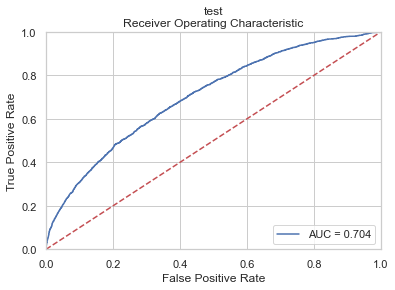

In [37]:
# plot roc curve
roc_auc = plt_auc(model,X_test[num_of_eval:,:],y_test[num_of_eval:],'test')

In [35]:
y_pred = model.predict_proba(X_test[num_of_eval:,:])[:,1]
y_pred = [1 if i > 0.18 else 0 for i in y_pred] # choose difference threshold to meet different requirements
print("Recall: ", recall_score(y_test[num_of_eval:],y_pred)) 
print("Precision: ", precision_score(y_test[num_of_eval:],y_pred))
print("Accuracy: ", accuracy_score(y_test[num_of_eval:],y_pred))
print("F1: ", f1_score(y_test[num_of_eval:],y_pred))

Recall:  0.11620517476168861
Precision:  0.24060150375939848
Accuracy:  0.9414091576104294
F1:  0.15671870217324763


In [58]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import regularizers
import math
import matplotlib.pyplot as plt

In [41]:
def get_train_test(df, split_percent=0.8):
    df = df
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

In [42]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

In [52]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, kernel_initializer='random_uniform',activity_regularizer=regularizers.l1(0.0001),activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model

In [44]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))  

In [45]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
 

In [53]:
cust_data_subset.dtypes

transaction_dt      datetime64[ns]
customer_id                 object
age_int                      int64
product_subclass             int64
product_id                   int64
pin_code_int                 int64
asset                        int64
amount                       int64
sales_price                  int64
year                         int64
month                        int64
week                        UInt32
day                          int64
unit_price                 float64
trans_id                    object
dtype: object

In [54]:
cust_data_subset1=cust_data_subset.drop(['transaction_dt'], axis=1)

In [55]:
cust_data_subset1.dtypes

customer_id          object
age_int               int64
product_subclass      int64
product_id            int64
pin_code_int          int64
asset                 int64
amount                int64
sales_price           int64
year                  int64
month                 int64
week                 UInt32
day                   int64
unit_price          float64
trans_id             object
dtype: object

In [56]:
df = cust_data_subset1
time_steps = 12
train_data, test_data, data = get_train_test(df)
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [59]:
# Create model and train
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['relu', 'relu'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
763224/763224 - 1165s - loss: 0.1049 - 1165s/epoch - 2ms/step
Epoch 2/20
763224/763224 - 1139s - loss: 0.1044 - 1139s/epoch - 1ms/step
Epoch 3/20
763224/763224 - 1294s - loss: 0.1044 - 1294s/epoch - 2ms/step
Epoch 4/20
763224/763224 - 1194s - loss: 0.1044 - 1194s/epoch - 2ms/step
Epoch 5/20
763224/763224 - 1091s - loss: 0.1044 - 1091s/epoch - 1ms/step
Epoch 6/20
763224/763224 - 1083s - loss: 0.1044 - 1083s/epoch - 1ms/step
Epoch 7/20
763224/763224 - 1081s - loss: 0.1044 - 1081s/epoch - 1ms/step
Epoch 8/20
763224/763224 - 939s - loss: 0.1044 - 939s/epoch - 1ms/step
Epoch 9/20
763224/763224 - 919s - loss: 0.1044 - 919s/epoch - 1ms/step
Epoch 10/20
763224/763224 - 916s - loss: 0.1044 - 916s/epoch - 1ms/step
Epoch 11/20
763224/763224 - 909s - loss: 0.1044 - 909s/epoch - 1ms/step
Epoch 12/20
763224/763224 - 917s - loss: 0.1044 - 917s/epoch - 1ms/step
Epoch 13/20
763224/763224 - 982s - loss: 0.1044 - 982s/epoch - 1ms/step
Epoch 14/20
763224/763224 - 948s - loss: 0.1044 - 948s/epoc

In [60]:
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

In [61]:
# Print error
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.323 RMSE
Test RMSE: 0.353 RMSE


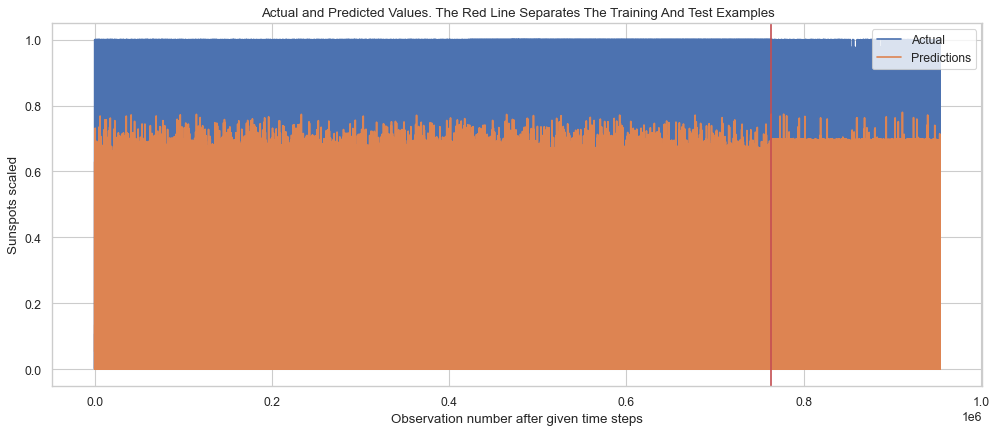

In [62]:
#Plot result
plot_result(trainY, testY, train_predict, test_predict)